In [1]:
import glob
from os import getcwd
from os.path import join
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot 
import matplotlib.pyplot as plt

from collections import Counter



In [2]:
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures

from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.summarize import WindowSummarizer

In [3]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score 



# Data processing

### Raw data 

In [4]:
path = join(getcwd()[:-len('code')], 'fulldata','High_techcamputOost_P4.csv')
techCamp = pd.read_csv(path, header = 0, sep = ',')
techCamp.head()

,EvseId,Created,ExternalId,DurationSeconds,VolumeKwh,TariffCode,WholesaleCost
0,NL-GFX-ENL-GFX-RD00274-2,2022-05-30 10:41:16.2820000,NLGFX637894848203153288-fa347,19255,15.09,A2,4.53
1,NL-GFX-ENL-GFX-RD00265-2,2022-09-02 12:40:41.2880000,NLGFX637976966424191918-7e64d,22598,21.15,A2,6.35
2,NL-GFX-ENL-GFX-RD00274-2,2022-04-14 15:39:58.1317664,NLGFX637855148498851366-5d792,32748,44.94,A2,13.48
3,NL-GFX-ENL-GFX-RD00298-1,2022-05-23 14:48:21.4670000,NLGFX637888818910573415-70dbb,32209,10.13,A2,3.04
4,NL-GFX-EJLZ-J0034-1,2022-09-08 16:06:55.9930000,NLGFX637982393543662442-da421,10674,21.11,A2,6.33


In [5]:
def sumarizingsaledata(rawdf):
    dt  = rawdf[['Created', 'WholesaleCost']].copy()
    day = pd.to_datetime(dt['Created']).dt.date
    del dt['Created']
    dt['date'] = day
    dt = dt.groupby(by = 'date').agg({'date':'count', 'WholesaleCost': 'sum'})
    dt = dt.rename(columns={"date": "noVisitors", 'WholesaleCost': 'sales'})
    dt.index = pd.to_datetime(dt.index) 
    new_index = pd.date_range(start=dt.index.min(), end=dt.index.max(), freq="D")
    dt = dt.reindex(new_index, fill_value=0)
    dt = dt[['sales', 'noVisitors']]
    dt.index.name = 'Date'
    return dt

In [6]:
dtTeC = sumarizingsaledata(techCamp)
dtTeC.head()

,sales,noVisitors
Date,,
2016-01-04,84.74,51
2016-01-05,0.00,0
2016-01-06,0.00,0
2016-01-07,0.00,0
2016-01-08,0.00,0


In [7]:
dt = dtTeC[['sales']].copy()

In [8]:
 dt.index.min(),dt.index.max()

(Timestamp('2016-01-04 00:00:00', freq='D'),
 Timestamp('2022-11-18 00:00:00', freq='D'))

Text(0.5, 0, 'Time')

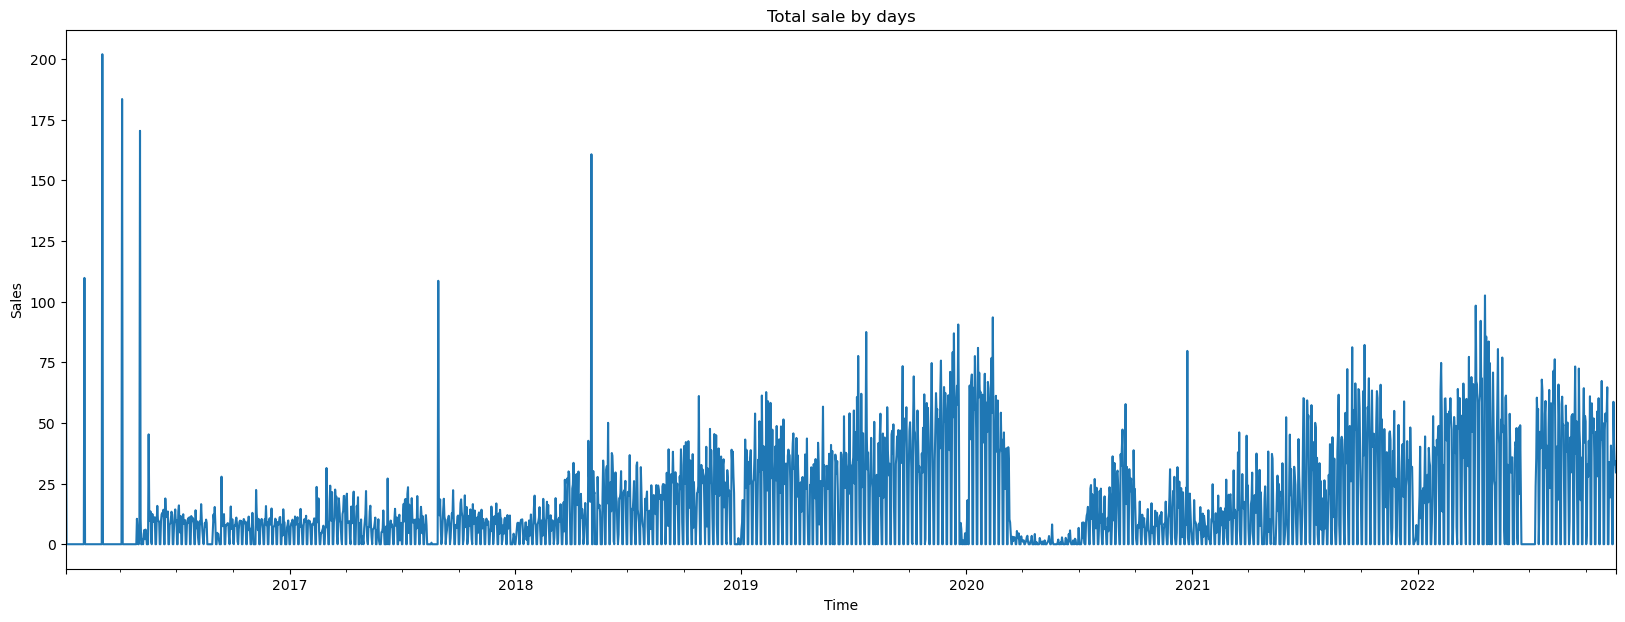

In [9]:
ax = dt['sales'].plot(figsize=[20, 7])
ax.set_title('Total sale by days')
ax.set_ylabel("Sales")
ax.set_xlabel("Time")

In [10]:
dt["week"] = dt.index.isocalendar().week
dt["day_of_week"] = dt.index.day_of_week
dt["day_of_month"] = dt.index.month
dt["month"] = dt.index.month
dt["year"] = dt.index.year
dt.head()

,sales,week,day_of_week,day_of_month,month,year
Date,,,,,,
2016-01-04,84.74,1,0,1,1,2016
2016-01-05,0.00,1,1,1,1,2016
2016-01-06,0.00,1,2,1,1,2016
2016-01-07,0.00,1,3,1,1,2016
2016-01-08,0.00,1,4,1,1,2016


In [11]:
# CHECKING PATTERN weekly Sales through 7 years
import math
def plotweeklydatabyyear(data, var, years):
    fig, ax = plt.subplots(nrows=math.ceil(len(years)/3), ncols=3, figsize=[20, 20], sharey=True)
    ax = ax.flatten()
    sns_blue = sns.color_palette(as_cmap=True)[0] # Get seaborn blue color

    DAYS = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    for ix, year in enumerate(years): # Iterate over each month
        weekly_ts = []
        for _, ts in ( 
            data[[var, "week", "year"]]
            .query(f"year== {year}") 
            .groupby("week") ):

            ts = ts.reset_index()
            weekly_ts.append(ts[var]) 
            ts[var].plot(
                alpha=0.1, ax=ax[ix], color=sns_blue, label="_no_legend_"
                )
            ax[ix].set_xticks(np.arange(0,7 ), labels=DAYS)
            ax[ix].set_title(year)


        pd.concat(weekly_ts, axis=1).mean(axis=1).plot(
            ax=ax[ix], color="blue", label="mean", legend=True
        ) 
        ax[ix].legend(loc="upper left", frameon=False)

        if year not in years[-3:]:
            ax[ix].tick_params(
                axis="x", which="both", bottom=False, top=False, labelbottom=False
            )
    fig.text(0.5, -0.02, "Day of the week", ha="center")
    fig.text(-0.02, 0.5, var, va="center", rotation="vertical")
    fig.suptitle("Weekly {} by year".format(var))
    if (3*math.ceil(len(years)/3))- len(years) ==1: 
        fig.delaxes(ax[-1])
    if (3*math.ceil(len(years)/3))- len(years) ==2: 
        fig.delaxes(ax[-1])
        fig.delaxes(ax[-2])
    fig.tight_layout()
    plt.show()
    

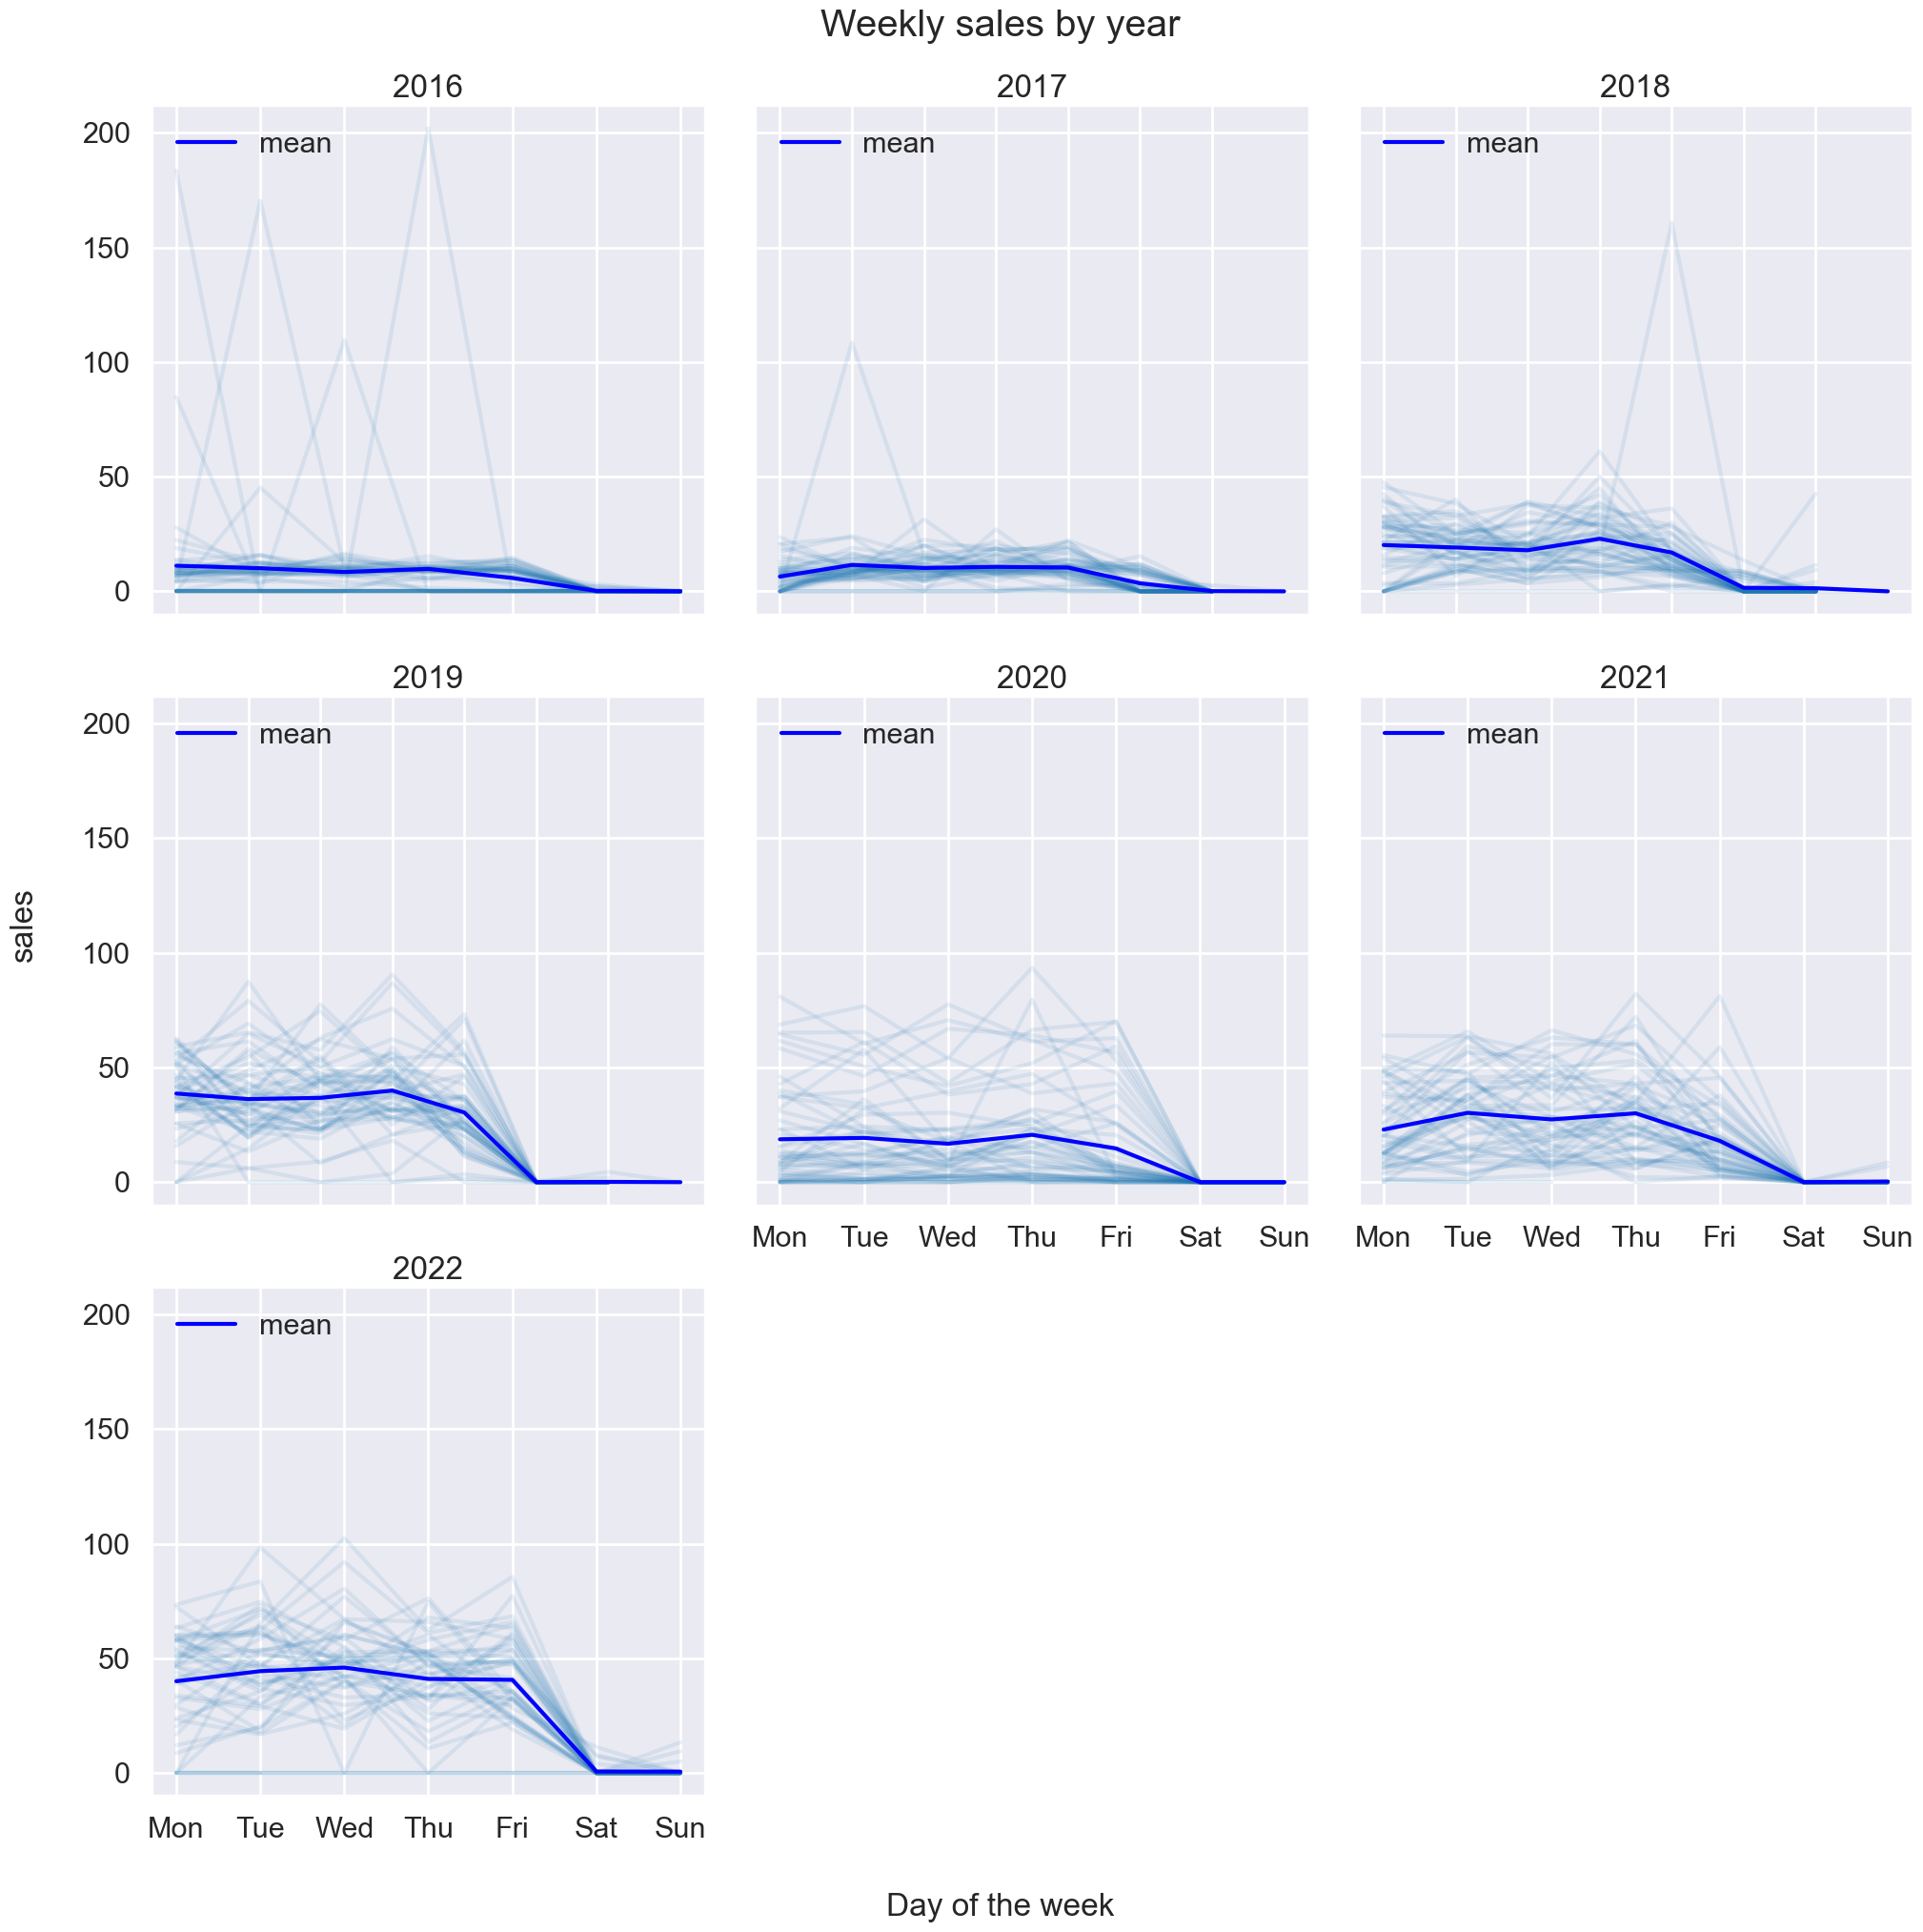

In [12]:
sns.set_style("darkgrid")
sns.set_context("poster")
years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
plotweeklydatabyyear(dt, 'sales', years)


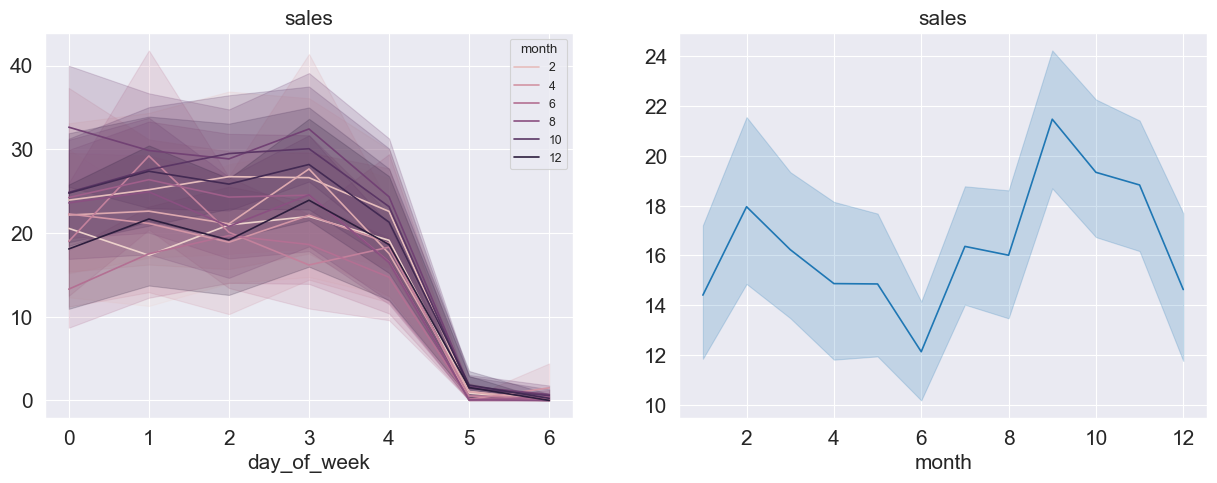

In [13]:
pd.plotting.register_matplotlib_converters()
variables = ['sales']
col_by_ylabel = {'Sales': 'euros'}
with sns.plotting_context("paper"):
    for var in variables:
        fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
        ylabel = col_by_ylabel.get(var)

        sns.lineplot(data=dt, y=var, x="day_of_week", hue="month", ax=ax[0])

        ax[0].set_ylabel(ylabel, fontsize = 15)
        ax[0].set_xlabel("day_of_week",fontsize = 15)
        ax[0].set_title(var,  size=15)
        ax[0].tick_params(axis='both', which='major', labelsize=15)


        sns.lineplot(x="month", y=var, data=dt, ax=ax[1])

        ax[1].set_ylabel(ylabel, fontsize = 15)
        ax[1].set_xlabel('month', fontsize = 15)
        ax[1].set_title(var, size = 15)
        ax[1].tick_params(axis='both', which='major', labelsize=15)


### Final data

In [14]:
sns.reset_defaults()

In [15]:
dt = dtTeC[['sales']].copy()

In [16]:
dt.index.max(), dt.index.min()

(Timestamp('2022-11-18 00:00:00', freq='D'),
 Timestamp('2016-01-04 00:00:00', freq='D'))

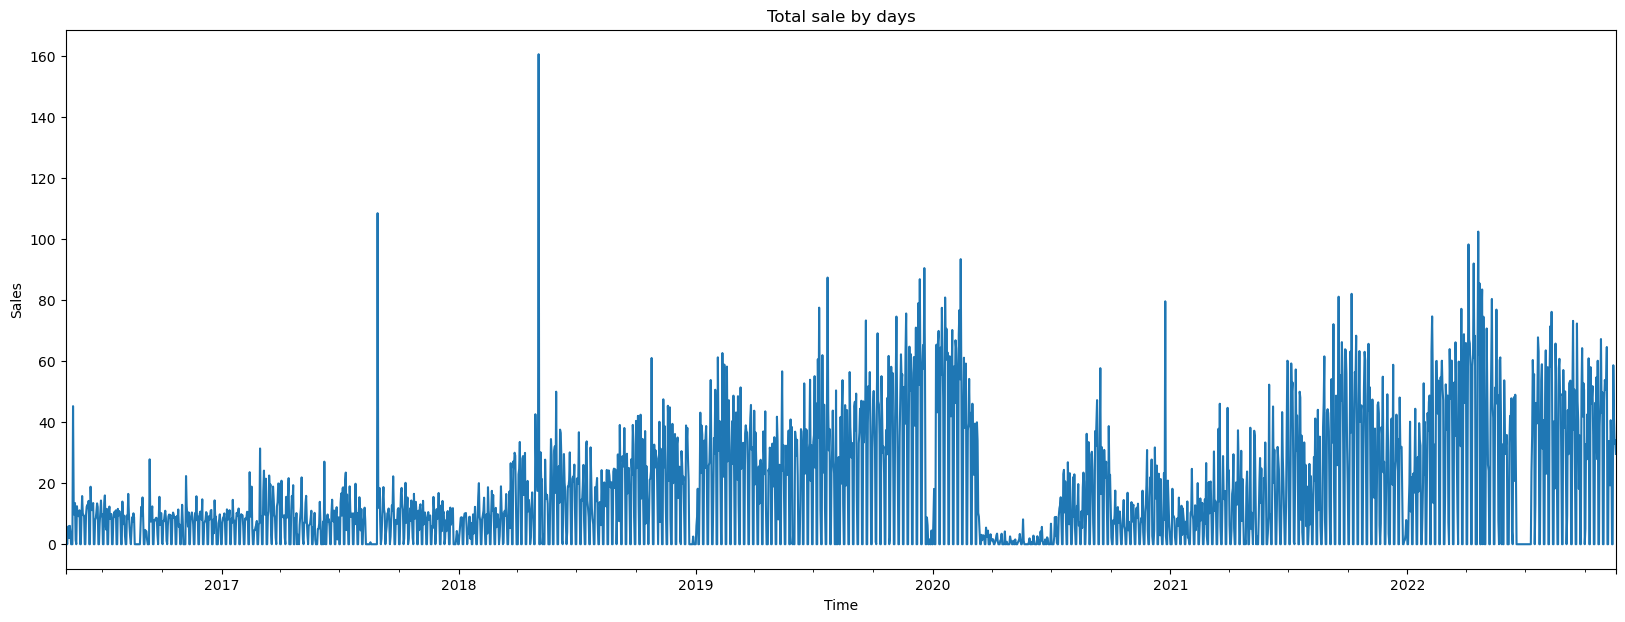

In [17]:
dt = dt.loc[dt.index >= '20160506' ]
ax = dt['sales'].plot(figsize=[20, 7])
ax.set_title('Total sale by days')
ax.set_ylabel("Sales")
ax.set_xlabel("Time")
plt.show()

In [18]:
# Flagging covid
covidid = dt[[]].copy()
covidid['covidrules'] = 0
rules = {'rule1': [('20200307','20200311'), ('20200806','20201013'), ('20210331','20210518'),
                   ('20210710','20210829'), ('20211103','20211218'), ('20220115','20220224')],
         'rule2': [('20200312','20200510'), ('20201014','20201213'), ('20210208','20210330'), 
                   ('20220110','20220114')],
         'rule3': [('20201214','20210207'), ('20211219', '20220109')]
        }


for ix, r in enumerate(list(rules.keys())): 
    for timeline in rules[r]:
        covidid.loc[(covidid.index >=timeline[0])&(covidid.index <=timeline[1]), 'covidrules'] = ix +1
dt = dt.join(covidid, how="left")
dt.shape


(2388, 2)

In [19]:
# Flagging abnormal event 

abnormaltime = ('20220620','20220708')
abnormalevent = dt[[]].copy()
abnormalevent['abnormal_event'] = 0
abnormalevent.loc[(abnormalevent.index >=abnormaltime[0])
                   &(abnormalevent.index <=abnormaltime[1]), 
                   'abnormal_event'] = 1
dt = dt.join(abnormalevent, how="left")
dt.head()

,sales,covidrules,abnormal_event
Date,,,
2016-05-06,0.00,0,0
2016-05-07,2.19,0,0
2016-05-08,0.00,0,0
2016-05-09,4.25,0,0
2016-05-10,5.89,0,0


In [20]:
# Flagging holidays
from pandas.tseries.holiday import (
    Holiday,
    AbstractHolidayCalendar, # provides all the necessary methods to return a list of holidays
    nearest_workday, # rule
    GoodFriday,
    EasterMonday)

In [21]:
class NLHolidays(AbstractHolidayCalendar):
    rules = [
        GoodFriday,
        EasterMonday,
        Holiday("New Year's Day", month=1, day=1, observance=nearest_workday),
        Holiday("Kings Day", month=4, day=27),
        Holiday('Christmas', month=12, day=25),
        Holiday('Boxing day', month=12, day=26,observance=nearest_workday),  
    ]
cal = NLHolidays()
cal.rules

[Holiday: Good Friday (month=1, day=1, offset=[<Easter>, <-2 * Days>]),
 Holiday: Easter Monday (month=1, day=1, offset=[<Easter>, <Day>]),
 Holiday: New Year's Day (month=1, day=1, observance=<function nearest_workday at 0x000001FEFBFA8E50>),
 Holiday: Kings Day (month=4, day=27, ),
 Holiday: Christmas (month=12, day=25, ),
 Holiday: Boxing day (month=12, day=26, observance=<function nearest_workday at 0x000001FEFBFA8E50>)]

In [22]:
nl_holidays = cal.holidays(dt.index.min(), dt.index.max())

dt["holidays"] = np.where(dt.index.isin(nl_holidays),1,0)


In [23]:
# Setting up feature
features_to_lag = ['sales']
sincos_cycle = ["week", "month", "day_of_week", "day_of_year"]

#mean weight scaler
def weighted_mean3(x):
    weights = np.arange(1, 3 +1)  #ranking [1,2,3]
    return (weights * x).sum() / weights.sum()
def weighted_mean7(x):
    weights = np.arange(1, 7+1)  # Ranking [1,2,...,7]
    return (weights * x).sum() / weights.sum()
def weighted_mean14(x):
    weights = np.arange(1, 14+1)  
    return (weights * x).sum() / weights.sum()

# std weight scaler
def weighted_std3(x):
    weights = np.arange(1, 3 +1)
    mean_w = weighted_mean3(x)
    var_w = (weights * (x - mean_w)**2).sum() / weights.sum()
    return np.sqrt(var_w)

def weighted_std7(x):
    weights = np.arange(1, 7 +1)
    mean_w = weighted_mean7(x)
    var_w = (weights * (x - mean_w)**2).sum() / weights.sum()
    return np.sqrt(var_w)

def weighted_std14(x):
    weights = np.arange(1, 14 +1)
    mean_w = weighted_mean14(x)
    var_w = (weights * (x - mean_w)**2).sum() / weights.sum()
    return np.sqrt(var_w)



In [24]:
lagwindows = np.arange(1,29)
lagwindows

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [25]:
shift = np.ones(5,dtype=np.int8)
rollingsize = np.arange(7,29,7)
rollingsize = np.insert(rollingsize,0, 3, axis=0)
rollingwidow =np.vstack((shift, rollingsize)).T
rollingwidow

array([[ 1,  3],
       [ 1,  7],
       [ 1, 14],
       [ 1, 21],
       [ 1, 28]])

In [26]:
def transformdata(data, features_to_lag):
    data['year'] = data.index.year
    year_enc = (data.groupby(['year'])['sales']
                .expanding()
                .mean()
                .shift()).reset_index()
    year_enc.rename(columns = {"sales": "year_enc"}, inplace = True)
    del year_enc['year']
    year_enc = year_enc.set_index('Date')

    data = year_enc.join(data['sales'], how = 'left')
    
    datetimeF = DatetimeFeatures(
        variables="index",
        features_to_extract=["weekend", #keep
                             #drop after cyclical transformer
                             "week",
                             "month",
                             "day_of_year",
                             "day_of_week"] )
    
    sincos = CyclicalFeatures(variables = sincos_cycle, 
                              drop_original = True)
    #normal window and lag
    winflagf = WindowSummarizer(
        lag_feature = {'lag':lagwindows,
                       'mean' : rollingwidow,
                       'max' :rollingwidow,
                       'min': [[1,3]],
                       'std' : rollingwidow,
                        weighted_mean3: [[1,3]],
                        weighted_std3: [[1,3]],
                        weighted_mean7: [[1,7]],
                        weighted_std7: [[1,7]], 
                        weighted_mean14: [[1,14]],
                        weighted_std14: [[1,14]],},
        target_cols = features_to_lag )
 
    imputer = DropMissingData()
    pipe = Pipeline([("datetime_features", datetimeF),
                     ('periodic', sincos),
                     ("lag_win_f", winflagf),
                     ("dropna", imputer),])
    result = pipe.fit_transform(data)
    
    return result



transformdata(dt,features_to_lag).columns

Index(['sales_lag_1', 'sales_lag_24', 'sales_lag_5', 'sales_lag_6',
       'sales_lag_23', 'sales_lag_7', 'sales_lag_8', 'sales_lag_22',
       'sales_lag_27', 'sales_lag_28', 'sales_lag_4', 'sales_lag_10',
       'sales_lag_11', 'sales_lag_20', 'sales_lag_12', 'sales_lag_13',
       'sales_lag_19', 'sales_lag_14', 'sales_lag_15', 'sales_lag_18',
       'sales_lag_16', 'sales_lag_21', 'sales_lag_25', 'sales_lag_9',
       'sales_lag_17', 'sales_lag_3', 'sales_lag_2', 'sales_lag_26',
       'sales_mean_1_7', 'sales_mean_1_14', 'sales_mean_1_3',
       'sales_mean_1_21', 'sales_mean_1_28', 'sales_max_1_14', 'sales_max_1_7',
       'sales_max_1_28', 'sales_max_1_3', 'sales_max_1_21', 'sales_min_1_3',
       'sales_std_1_14', 'sales_std_1_3', 'sales_std_1_7', 'sales_std_1_28',
       'sales_std_1_21', 'sales_weighted_mean3_1_3', 'sales_weighted_std3_1_3',
       'sales_weighted_mean7_1_7', 'sales_weighted_std7_1_7',
       'sales_weighted_mean14_1_14', 'sales_weighted_std14_1_14', 'year_en

In [27]:
target = dt[['sales']]
target

,sales
Date,
2016-05-06,0.00
2016-05-07,2.19
2016-05-08,0.00
2016-05-09,4.25
2016-05-10,5.89
...,...
2022-11-14,58.70
2022-11-15,41.35
2022-11-16,32.95


In [28]:
all_ip = transformdata(dt, ['sales'])
all_ip.head()

,sales_lag_1,sales_lag_24,sales_lag_5,sales_lag_6,sales_lag_23,sales_lag_7,sales_lag_8,sales_lag_22,sales_lag_27,sales_lag_28,...,year_enc,weekend,week_sin,week_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-03,9.52,5.89,0.00,0.00,2.06,11.12,9.19,6.03,2.19,0.00,...,7.256429,0,0.508531,-0.861044,1.224647e-16,-1.0,-8.660254e-01,-0.5,0.462383,-0.886680
2016-06-04,9.30,2.06,9.06,0.00,6.03,0.00,11.12,3.93,0.00,2.19,...,7.326897,1,0.508531,-0.861044,1.224647e-16,-1.0,-8.660254e-01,0.5,0.447094,-0.894487
2016-06-05,0.00,6.03,15.80,9.06,3.93,0.00,0.00,0.00,4.25,0.00,...,7.082667,1,0.508531,-0.861044,1.224647e-16,-1.0,-2.449294e-16,1.0,0.431673,-0.902030
2016-06-06,0.00,3.93,10.15,15.80,0.00,9.06,0.00,0.00,5.89,4.25,...,6.854194,0,0.403123,-0.915146,1.224647e-16,-1.0,0.000000e+00,1.0,0.416125,-0.909308
2016-06-07,9.67,0.00,9.52,10.15,0.00,15.80,9.06,0.00,2.06,5.89,...,6.942188,0,0.403123,-0.915146,1.224647e-16,-1.0,8.660254e-01,0.5,0.400454,-0.916317


In [29]:

test_corr_df = target.join(all_ip, how = 'right')
corr_matrix = test_corr_df.reset_index().drop('Date', axis = 1).corr()

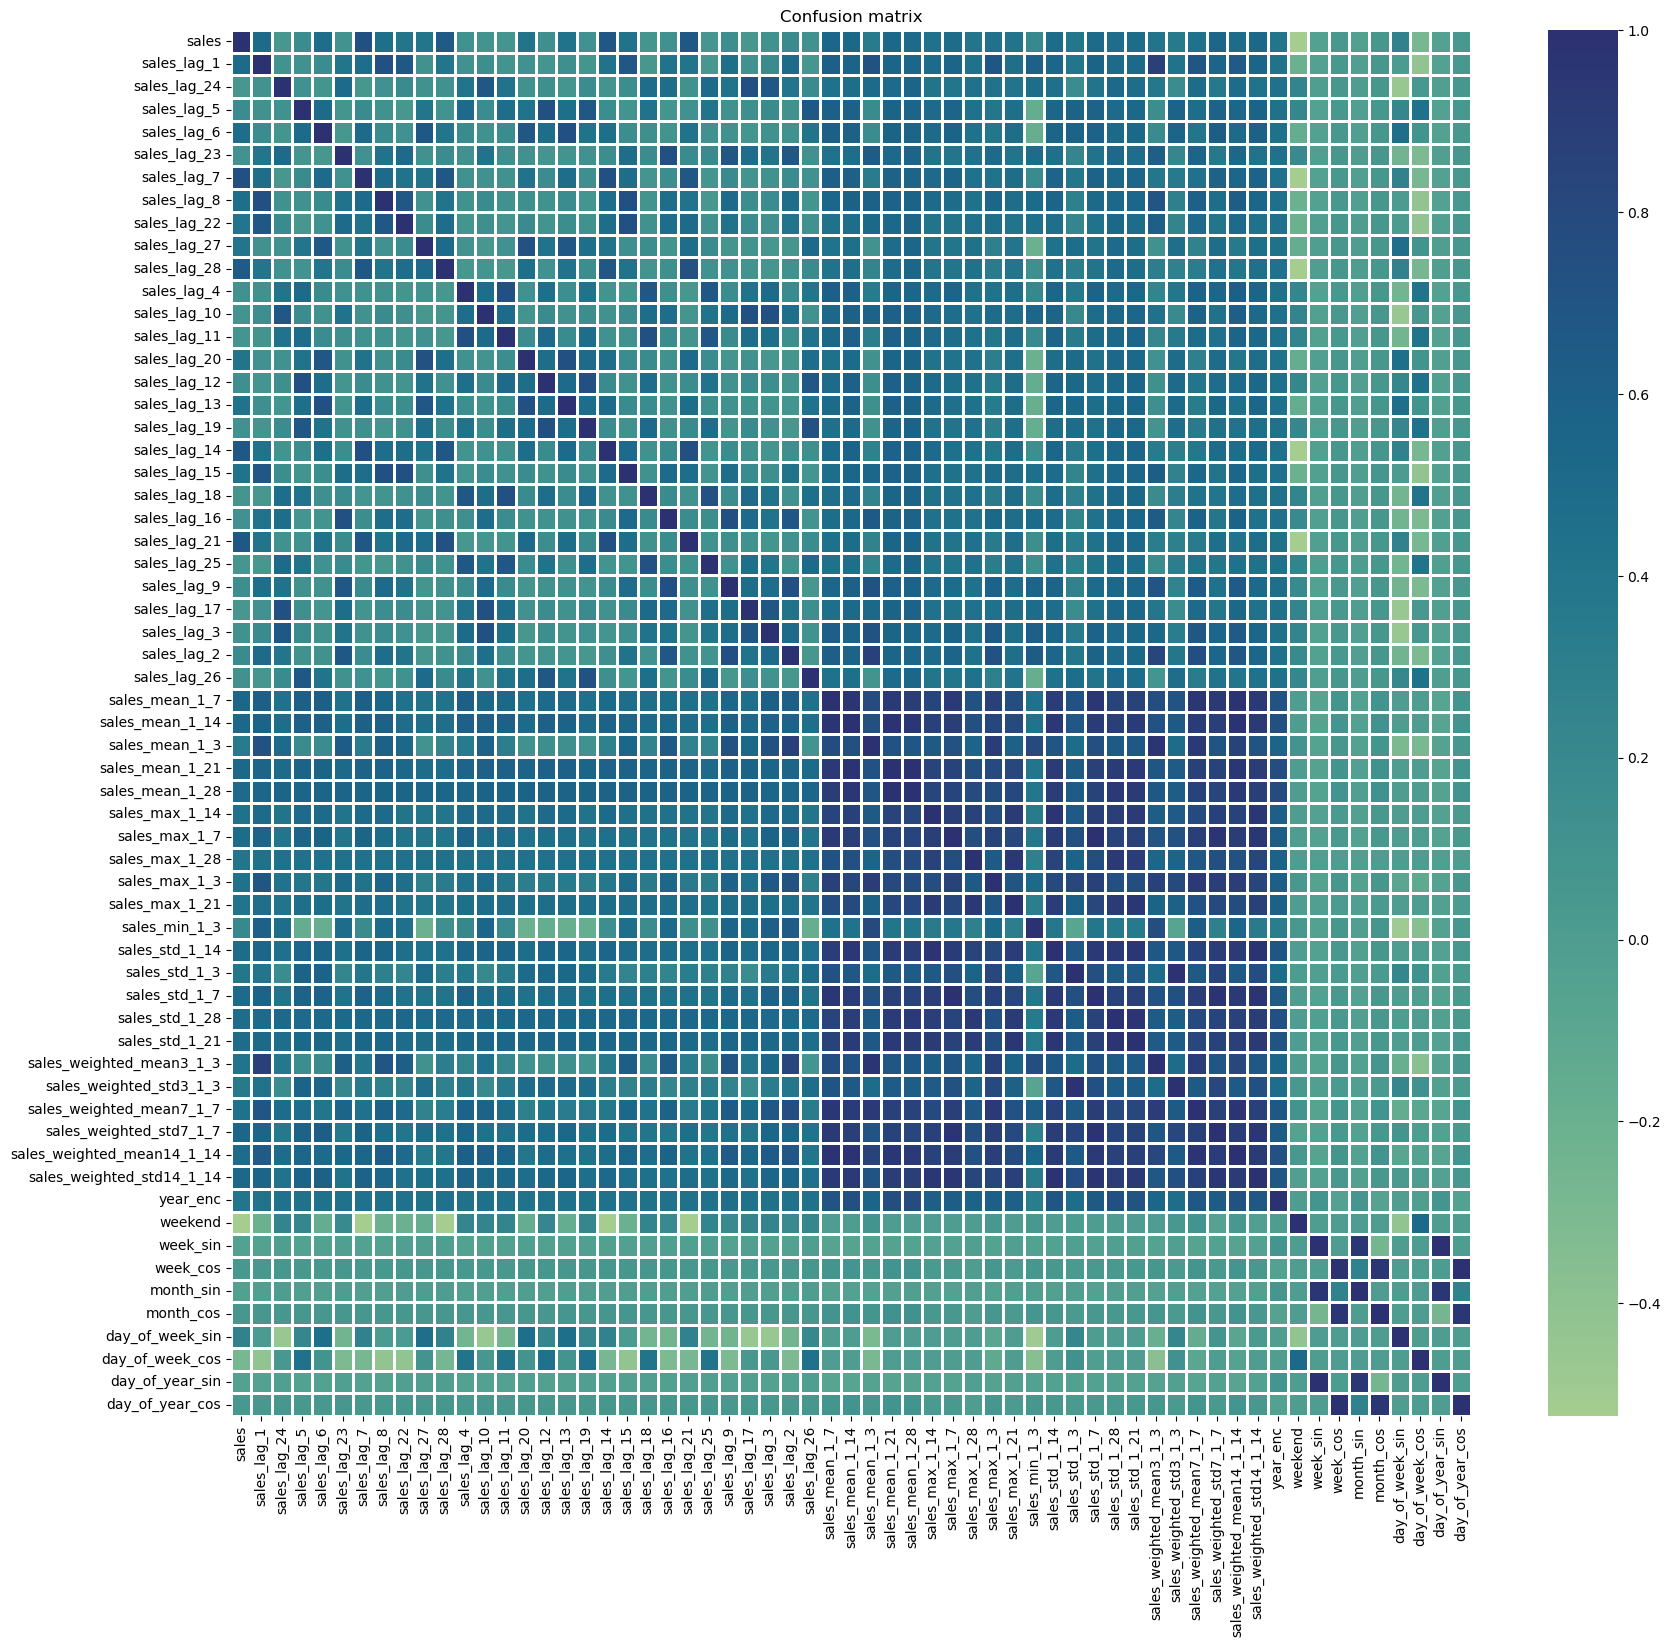

In [30]:


plt.figure(figsize=(20,18))
sns.heatmap(corr_matrix,annot=False,linewidth=.9,cmap='crest')
plt.title("Confusion matrix")
plt.show()

In [31]:
#matching target and input
target = target.loc[all_ip.index]
target.shape, all_ip.shape

((2360, 1), (2360, 60))

In [32]:
# Spliting point
predicting_point_test = pd.Timestamp('2022-09-02')

xtrain = all_ip.loc[all_ip.index < predicting_point_test]

xtest = all_ip.loc[all_ip.index >= predicting_point_test]

ytrain = target.loc[target.index < predicting_point_test]
ytest = target.loc[target.index >= predicting_point_test]


In [33]:
xtrain.shape, ytrain.shape

((2282, 60), (2282, 1))

In [34]:
xtest.shape, ytest.shape

((78, 60), (78, 1))

### Prediction mesuares for linear models

In [35]:
# 3 main measures
# Metrics:
def getmetrics(true, pred):
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    return mae, r2

# Accuracy:

def get_pre(true, pred,threshold = 0.1): # the difference is not bigger than 3
    TP = 0
    for i in range(len(true)):
        if true.iloc[i]['sales'] == 0:
            if abs(true.iloc[i]['sales']-pred[i]) <= 3:
                TP +=1 
        else:
            if abs(true.iloc[i]['sales']-pred[i])/true.iloc[i]['sales'] <= threshold:
                TP +=1
    return TP/len(true)



In [36]:
# Plot prediction
%matplotlib inline
def plotprediction(true, pred, modelname):
    pred_table = pd.DataFrame({'preds': pred}, index = true.index)
    prediction_table = true.join(pred_table)
    prediction_table = prediction_table.rename(columns = {'sales': 'true'})
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(prediction_table['true'], label='Truth')
    ax.plot(prediction_table['preds'], label='Prediction')
    ax.set_title('Comparing prediction from {}'.format(modelname), fontsize=20)
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('Intensity', fontsize=16)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)
    leg = ax.legend(fontsize = 18)


# Model implementation

For linear model, using Grid search to tune model: 

    - 5 fold cross validation will be implemented in Gridseard, 
    Thus, valset will be stacked back to trainset

### Baseline Linear model: OLS

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


r2_scorer = make_scorer(r2_score)
all_outcome = {}

In [38]:
param_grid_lr = {'lr__fit_intercept':[True, False]} 
pipe_lr = Pipeline(steps=[('scaler',StandardScaler(with_mean=False, 
                                                   with_std=False)),
                          ('lr',LinearRegression())])

In [39]:
grid_lr = GridSearchCV(pipe_lr, param_grid_lr
                       , cv = 5, scoring = r2_scorer)

In [40]:
grid_lr.fit(xtrain, ytrain)
grid_lr.best_score_, grid_lr.best_params_

(0.4495437173491073, {'lr__fit_intercept': True})

In [41]:

ols_preds = grid_lr.predict(xtest)

OLStest_out = {'mae': getmetrics(ytest, ols_preds)[0], 
               'r2':getmetrics(ytest, ols_preds)[1], 
               'precision': get_pre(ytest, ols_preds)}

all_outcome['OLS'] = OLStest_out

OLStest_out

{'mae': 9.420871401673502,
 'r2': 0.6875521814955485,
 'precision': 0.2948717948717949}

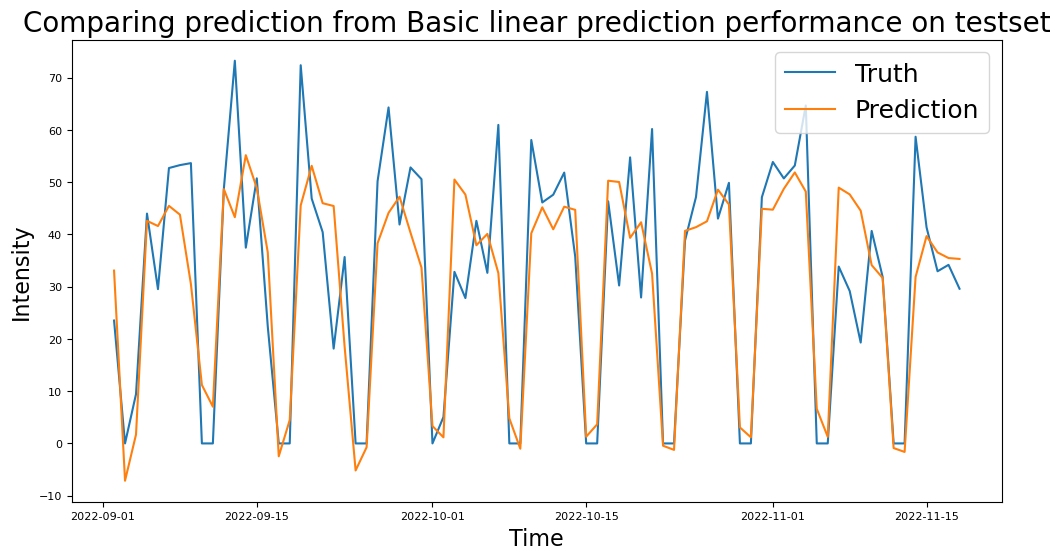

In [42]:
plotprediction(ytest, ols_preds.flatten(), 
               'Basic linear prediction performance on testset')

# Lasso Linear

In [43]:
# Grid search
param_grid_ls = {'ls__alpha':[0.01, 0.1, 1, 10, 100],
                 'ls__selection':['cyclic','random']}
pipe_ls = Pipeline(steps=[('scaler',StandardScaler(with_mean=False, 
                                                   with_std=False)),
                          ('ls',Lasso(random_state=0, max_iter=50000))])

In [44]:
grid_ls = GridSearchCV(pipe_ls, param_grid_ls
                       , cv = 5, scoring = r2_scorer)

In [45]:
grid_ls.fit(xtrain, ytrain)
grid_ls.best_score_, grid_ls.best_params_

(0.4574573574416073, {'ls__alpha': 0.1, 'ls__selection': 'cyclic'})

In [46]:
ls_preds = grid_ls.predict(xtest)

LSTest_out = {'mae': getmetrics(ytest, ls_preds)[0], 
               'r2':getmetrics(ytest, ls_preds)[1], 
               'precision': get_pre(ytest, ls_preds)}
all_outcome['lasso']: LSTest_out
LSTest_out


{'mae': 9.466884611520115,
 'r2': 0.683863894914469,
 'precision': 0.3076923076923077}

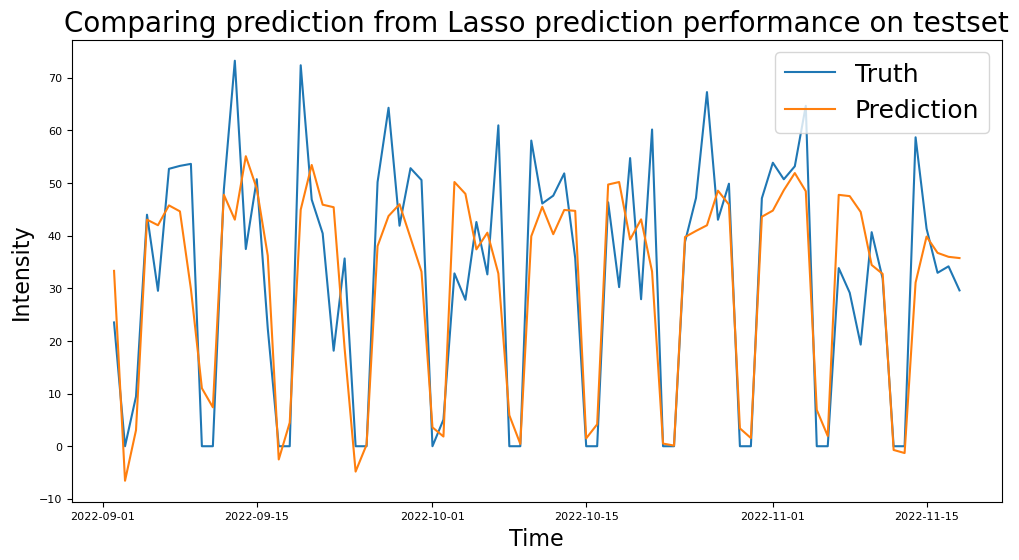

In [47]:
plotprediction(ytest, ls_preds, 
               'Lasso prediction performance on testset')

# Ridge Linear

In [48]:
# Grid search
param_grid_rid = {'rid__alpha':[0.01, 0.1, 1, 10, 100],
                 'rid__solver':['svd', 'cholesky', 'sparse_cg', 'lsqr', 'sag']}
pipe_rid = Pipeline(steps=[('scaler',StandardScaler(with_mean=False, 
                                                   with_std=False)),
                          ('rid',Ridge(random_state=0, max_iter=50000))])

In [49]:
grid_rid = GridSearchCV(pipe_rid, param_grid_rid
                       , cv = 5, scoring = r2_scorer)

In [50]:
grid_rid.fit(xtrain, ytrain)
grid_rid.best_score_, grid_rid.best_params_

(0.4617327957204336, {'rid__alpha': 0.01, 'rid__solver': 'sparse_cg'})

In [51]:

rid_preds = grid_rid.predict(xtest)

RidTest_out = {'mae': getmetrics(ytest, rid_preds)[0], 
               'r2':getmetrics(ytest, rid_preds)[1], 
               'precision': get_pre(ytest, rid_preds)}
all_outcome['Ridge']=RidTest_out
RidTest_out


{'mae': 9.511611647906854,
 'r2': 0.6785148024574038,
 'precision': 0.3076923076923077}

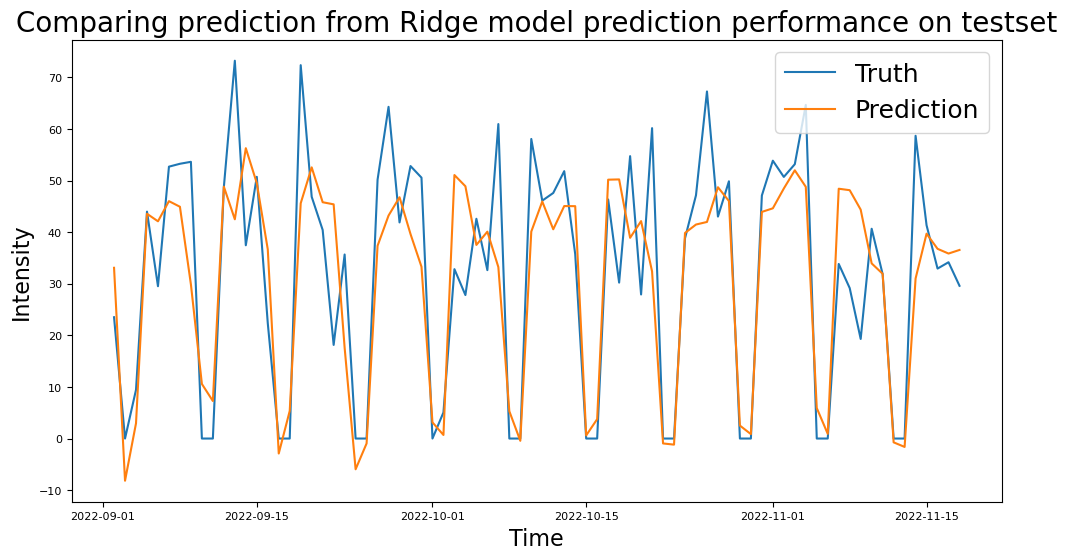

In [52]:
plotprediction(ytest, rid_preds.flatten(), 
               'Ridge model prediction performance on testset')

# KNN Knearest neighbors

In [53]:
# Grid search
param_grid_knn = {'knn__n_neighbors' : [5,10,15,20],
                  'knn__weights':['uniform', 'distance']}
pipe_knn = Pipeline(steps=[('scaler',StandardScaler(with_mean=False, 
                                                   with_std=False)),
                          ('knn',KNeighborsRegressor())])

grid_knn = GridSearchCV(pipe_knn, param_grid_knn
                       , cv = 5, scoring = r2_scorer)

grid_knn.fit(xtrain, ytrain)
grid_knn.best_score_, grid_knn.best_params_



(0.42211683907815073, {'knn__n_neighbors': 20, 'knn__weights': 'uniform'})

In [54]:
knn_preds = grid_knn.predict(xtest)

knn_out = {'mae': getmetrics(ytest, knn_preds)[0], 
               'r2':getmetrics(ytest, knn_preds)[1], 
               'precision': get_pre(ytest, knn_preds)}
all_outcome['KNN20']=knn_out

knn_out




{'mae': 8.48646794871795,
 'r2': 0.7115878170707534,
 'precision': 0.4358974358974359}

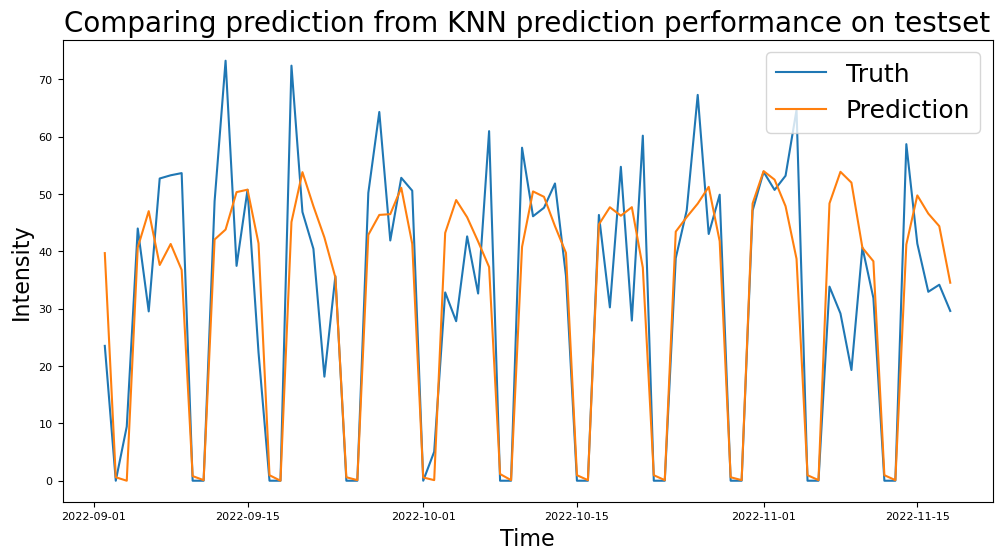

In [55]:
plotprediction(ytest, knn_preds.flatten(), 
               'KNN prediction performance on testset')

In [56]:
# KNN 5 by default
param_grid_knn5 = {'knn5__weights':['uniform', 'distance']}
pipe_knn5 = Pipeline(steps=[('scaler',StandardScaler(with_mean=False, 
                                                   with_std=False)),
                          ('knn5',KNeighborsRegressor())])

In [57]:
knn5 = KNeighborsRegressor( weights='uniform').fit(xtrain, ytrain)
knn5_preds = knn5.predict(xtest)

knn5_out = {'mae': getmetrics(ytest, knn5_preds)[0], 
               'r2':getmetrics(ytest, knn5_preds)[1], 
               'precision': get_pre(ytest, knn5_preds)}
all_outcome['KNN5']=knn5_out
knn5_out


{'mae': 8.418846153846156,
 'r2': 0.6939403142399021,
 'precision': 0.47435897435897434}

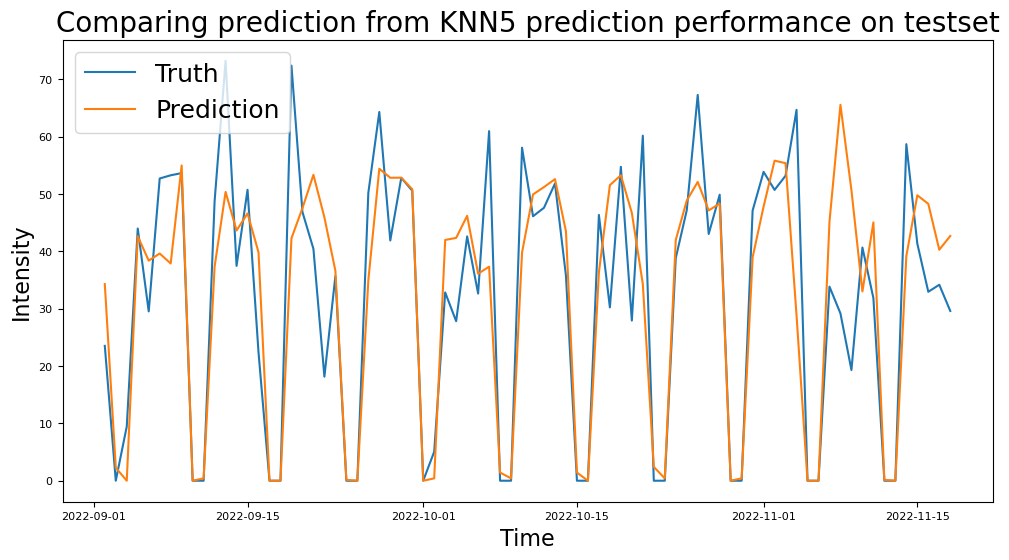

In [58]:
plotprediction(ytest, knn5_preds.flatten(), 
               'KNN5 prediction performance on testset')

# MLP

In [59]:
from sklearn.neural_network import MLPRegressor

In [60]:
# normal
mlp0 = MLPRegressor(hidden_layer_sizes=(128,64,16), activation='relu',
                    solver='adam',
                    alpha=0.0001,#L2
                    learning_rate='adaptive', 
                    max_iter=200, shuffle=False, random_state=None,
                    warm_start=False, momentum=0.9, 
                    early_stopping=True, validation_fraction=0.2
                    )

In [61]:
mlp0.fit(xtrain.values,np.ravel(ytrain,'C'))


MLPRegressor(early_stopping=True, hidden_layer_sizes=(128, 64, 16),
             learning_rate='adaptive', shuffle=False, validation_fraction=0.2)

In [62]:
mlp0_preds = mlp0.predict(xtest.values)

In [63]:
mlp0_out = {'mae': getmetrics(ytest, mlp0_preds)[0], 
               'r2':getmetrics(ytest, mlp0_preds)[1], 
               'precision': get_pre(ytest, mlp0_preds)}
all_outcome['mpl0']=mlp0_out
mlp0_out

{'mae': 9.108499942408526,
 'r2': 0.7052813066093744,
 'precision': 0.3717948717948718}

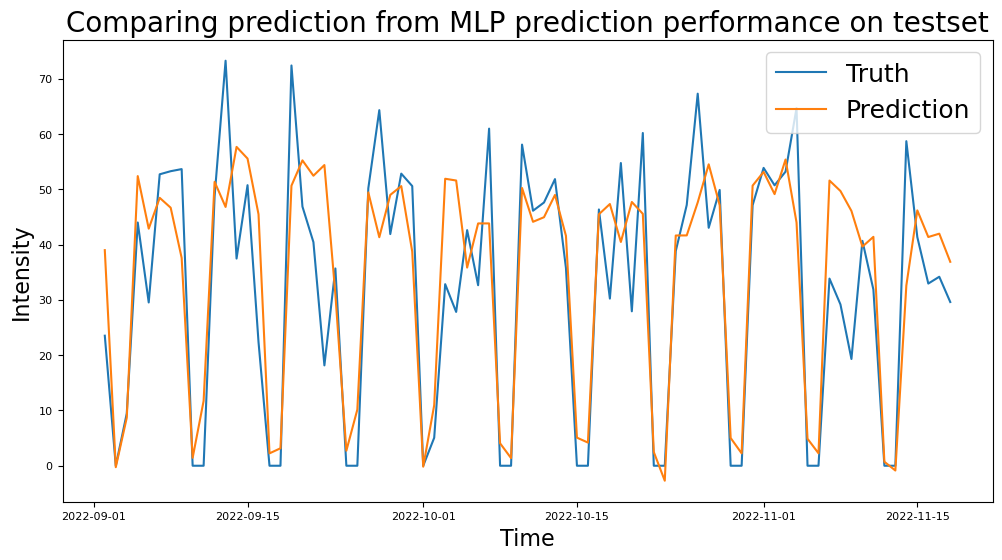

In [64]:
plotprediction(ytest, mlp0_preds, 
               'MLP prediction performance on testset')

In [65]:
# normal
mlp1 = MLPRegressor(hidden_layer_sizes=(256,128,64), activation='relu',
                    solver='adam',
                    alpha=0.0001,#L2
                    learning_rate='adaptive', 
                    max_iter=200, shuffle=False, random_state=None,
                    warm_start=False, momentum=0.8, 
                    early_stopping=True, validation_fraction=0.2
                    )

In [66]:
mlp1.fit(xtrain.values,np.ravel(ytrain,'C'))


MLPRegressor(early_stopping=True, hidden_layer_sizes=(256, 128, 64),
             learning_rate='adaptive', momentum=0.8, shuffle=False,
             validation_fraction=0.2)

In [67]:
mlp1_preds = mlp1.predict(xtest.values)

In [68]:
mlp1_out = {'mae': getmetrics(ytest, mlp1_preds)[0], 
               'r2':getmetrics(ytest, mlp1_preds)[1], 
               'precision': get_pre(ytest, mlp1_preds)}

all_outcome['mlp1']=mlp1_out
mlp1_out

{'mae': 9.581663702781768,
 'r2': 0.6626471766457669,
 'precision': 0.358974358974359}

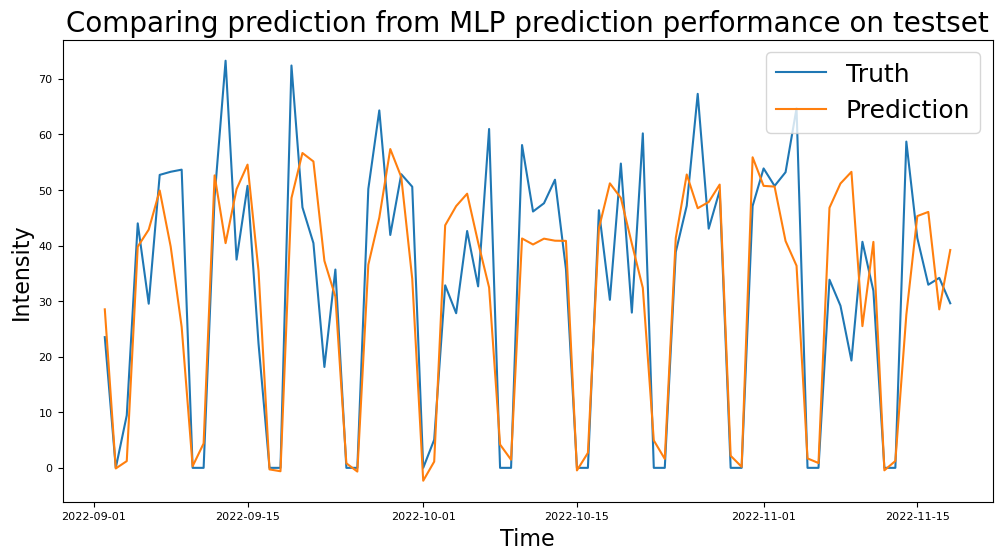

In [69]:
plotprediction(ytest, mlp1_preds, 
               'MLP prediction performance on testset')

### grid search 

In [70]:
# normal
param_grid_mlp = {'mlp__hidden_layer_sizes':[(256,128,64),
                                             (256,64,32),
                                            (128,64,16),
                                            (128,64,8)],
                  'mlp__activation':['relu','identity'],
                  'mlp__learning_rate':['constant','invscaling','adaptive'],
                 'mlp__momentum' :[0.8,0.9]}

pipe_mlp = Pipeline(steps=[('mlp',MLPRegressor(solver = 'adam',
                                              max_iter=200, shuffle=False,
                                               early_stopping=True, 
                                               validation_fraction=0.2))])

In [71]:
grid_mlp = GridSearchCV(pipe_mlp, param_grid_mlp
                       , cv = 5, scoring = r2_scorer)

In [72]:
grid_mlp.fit(xtrain.values, np.ravel(ytrain,'C'))
grid_mlp.best_score_, grid_mlp.best_params_

C:\Users\Eigenaar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.47746380967390234,
 {'mlp__activation': 'relu',
  'mlp__hidden_layer_sizes': (256, 128, 64),
  'mlp__learning_rate': 'adaptive',
  'mlp__momentum': 0.8})

In [73]:
mlpGrid_preds = grid_mlp.predict(xtest.values)
mlpGrid_out = {'mae': getmetrics(ytest, mlpGrid_preds)[0], 
               'r2':getmetrics(ytest, mlpGrid_preds)[1], 
               'precision': get_pre(ytest, mlpGrid_preds)}
all_outcome['mlpGrid'] = mlpGrid_out
mlpGrid_out


{'mae': 9.356057454750152,
 'r2': 0.6836892174812959,
 'precision': 0.3974358974358974}

In [74]:
all_outcome

{'OLS': {'mae': 9.420871401673502,
  'r2': 0.6875521814955485,
  'precision': 0.2948717948717949},
 'Ridge': {'mae': 9.511611647906854,
  'r2': 0.6785148024574038,
  'precision': 0.3076923076923077},
 'KNN20': {'mae': 8.48646794871795,
  'r2': 0.7115878170707534,
  'precision': 0.4358974358974359},
 'KNN5': {'mae': 8.418846153846156,
  'r2': 0.6939403142399021,
  'precision': 0.47435897435897434},
 'mpl0': {'mae': 9.108499942408526,
  'r2': 0.7052813066093744,
  'precision': 0.3717948717948718},
 'mlp1': {'mae': 9.581663702781768,
  'r2': 0.6626471766457669,
  'precision': 0.358974358974359},
 'mlpGrid': {'mae': 9.356057454750152,
  'r2': 0.6836892174812959,
  'precision': 0.3974358974358974}}

In [75]:
o_trs = {'mae':[], 'r2':[], 'precision':[]}
index = all_outcome.keys()
i =  0
for mod in index:
    for m in ['mae', 'r2', 'precision']:
        o_trs[m].append(all_outcome[mod][m])
    
pd.DataFrame(data=o_trs, index=index)

,mae,r2,precision
OLS,9.420871,0.687552,0.294872
Ridge,9.511612,0.678515,0.307692
KNN20,8.486468,0.711588,0.435897
KNN5,8.418846,0.693940,0.474359
mpl0,9.108500,0.705281,0.371795
mlp1,9.581664,0.662647,0.358974
mlpGrid,9.356057,0.683689,0.397436


## Applying chosen model to focast 30 days ahead

In [76]:
# The forecasting horizon.
horizon = 30

# Create an empty dataframe for the new targets.
full_target = pd.DataFrame(index=target.index)

for d in range(horizon):
    full_target[f"d_{d+1}"] = target.shift(periods=-d, freq="D")
full_target.shape
    

(2360, 30)

In [77]:
full_target[32:]

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-05,16.01,7.30,4.79,11.60,0.00,0.00,10.53,12.35,8.34,9.72,...,11.60,9.46,10.88,10.65,8.29,0.00,0.00,13.99,7.97,6.58
2016-07-06,7.30,4.79,11.60,0.00,0.00,10.53,12.35,8.34,9.72,9.92,...,9.46,10.88,10.65,8.29,0.00,0.00,13.99,7.97,6.58,9.38
2016-07-07,4.79,11.60,0.00,0.00,10.53,12.35,8.34,9.72,9.92,0.00,...,10.88,10.65,8.29,0.00,0.00,13.99,7.97,6.58,9.38,2.73
2016-07-08,11.60,0.00,0.00,10.53,12.35,8.34,9.72,9.92,0.00,0.00,...,10.65,8.29,0.00,0.00,13.99,7.97,6.58,9.38,2.73,0.00
2016-07-09,0.00,0.00,10.53,12.35,8.34,9.72,9.92,0.00,0.00,8.03,...,8.29,0.00,0.00,13.99,7.97,6.58,9.38,2.73,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-14,58.70,41.35,32.95,34.18,29.61,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-15,41.35,32.95,34.18,29.61,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-16,32.95,34.18,29.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
target

,sales
Date,
2016-06-03,9.30
2016-06-04,0.00
2016-06-05,0.00
2016-06-06,9.67
2016-06-07,12.29
...,...
2022-11-14,58.70
2022-11-15,41.35
2022-11-16,32.95


In [79]:
full_target.dropna(inplace=True)


iput = all_ip.loc[full_target.index]
full_target.shape,iput.shape, iput.index.min(), iput.index.max()

((2331, 30),
 (2331, 60),
 Timestamp('2016-06-03 00:00:00'),
 Timestamp('2022-10-20 00:00:00'))

In [80]:
# Spliting point
predicting_point_test = pd.Timestamp('2022-09-02')

xtrain = iput.loc[iput.index < predicting_point_test]

xtest = iput.loc[iput.index >= predicting_point_test]

ytrain = full_target.loc[full_target.index < predicting_point_test]
ytest = full_target.loc[full_target.index >= predicting_point_test]

In [81]:
ytest

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-02,23.52,0.00,9.45,43.99,29.53,52.71,53.27,53.65,0.00,0.00,...,18.15,35.68,0.00,0.00,50.19,64.31,41.90,52.83,50.58,0.00
2022-09-03,0.00,9.45,43.99,29.53,52.71,53.27,53.65,0.00,0.00,48.74,...,35.68,0.00,0.00,50.19,64.31,41.90,52.83,50.58,0.00,5.06
2022-09-04,9.45,43.99,29.53,52.71,53.27,53.65,0.00,0.00,48.74,73.25,...,0.00,0.00,50.19,64.31,41.90,52.83,50.58,0.00,5.06,32.84
2022-09-05,43.99,29.53,52.71,53.27,53.65,0.00,0.00,48.74,73.25,37.47,...,0.00,50.19,64.31,41.90,52.83,50.58,0.00,5.06,32.84,27.82
2022-09-06,29.53,52.71,53.27,53.65,0.00,0.00,48.74,73.25,37.47,50.74,...,50.19,64.31,41.90,52.83,50.58,0.00,5.06,32.84,27.82,42.61
2022-09-07,52.71,53.27,53.65,0.00,0.00,48.74,73.25,37.47,50.74,22.37,...,64.31,41.90,52.83,50.58,0.00,5.06,32.84,27.82,42.61,32.65
2022-09-08,53.27,53.65,0.00,0.00,48.74,73.25,37.47,50.74,22.37,0.00,...,41.90,52.83,50.58,0.00,5.06,32.84,27.82,42.61,32.65,60.97
2022-09-09,53.65,0.00,0.00,48.74,73.25,37.47,50.74,22.37,0.00,0.00,...,52.83,50.58,0.00,5.06,32.84,27.82,42.61,32.65,60.97,0.00
2022-09-10,0.00,0.00,48.74,73.25,37.47,50.74,22.37,0.00,0.00,72.39,...,50.58,0.00,5.06,32.84,27.82,42.61,32.65,60.97,0.00,0.00


In [97]:
all_preds = {'d_1':mlp1_preds[:len(mlp1_preds)-29]}

In [114]:
def pred_mlp1(ytrain_):
    mlp1 = MLPRegressor(hidden_layer_sizes=(256,128,64), activation='relu',
                    solver='adam',
                    alpha=0.0001,#L2
                    learning_rate='adaptive', 
                    max_iter=200, shuffle=False, random_state=None,
                    warm_start=False, momentum=0.8, 
                    early_stopping=True, validation_fraction=0.2
                    )
    mlp1.fit(xtrain.values, ytrain_)


    mlp1_preds = mlp1.predict(xtest.values)
    return mlp1_preds


In [115]:
for d in range(1,horizon):
    preds = pred_mlp1(np.array(ytrain[f"d_{d+1}"]))
    all_preds[f"d_{d+1}"] = preds
index = ytest.index
multi_o = pd.DataFrame(data=all_preds, index=index)
multi_o

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-02,28.519845,-2.258700,-1.933800,46.461166,41.432377,47.163121,41.484496,31.550276,-3.816709,4.082369,...,37.811013,31.479273,-3.882790,-5.103987,43.356732,39.138628,42.526628,35.662240,36.420554,-4.683171
2022-09-03,-0.107127,3.240875,43.431387,39.606326,51.277989,44.941015,29.782518,-5.449810,2.793178,41.833326,...,18.737298,-5.306597,4.741430,42.111242,38.400022,44.078234,41.438176,27.070186,-2.240505,0.408940
2022-09-04,1.212908,47.076645,44.355183,50.072451,46.258903,33.445677,-4.590141,3.631149,42.029904,35.127362,...,-0.609878,2.782122,41.086451,37.429256,41.704059,42.777671,34.170821,-1.344321,0.413185,39.493886
2022-09-05,39.787754,46.903147,46.427977,46.322439,31.240387,-0.820808,3.484300,42.458165,38.402412,34.863028,...,0.636942,44.466512,42.629013,39.115120,42.824721,26.905404,-1.847999,-0.322952,32.680769,38.676636
2022-09-06,42.861390,44.534207,46.701505,29.257302,3.830530,2.596730,38.175385,37.850485,41.636070,39.952717,...,35.397188,36.794978,37.811908,41.771537,26.743993,-7.921580,1.095440,31.800251,31.583064,38.796744
2022-09-07,49.910645,48.697476,29.706254,0.812945,1.940414,36.745722,39.637507,40.425417,46.664126,20.581157,...,32.041270,33.769841,33.914732,25.726853,-3.024547,3.519941,34.710235,32.310914,26.714757,45.351293
2022-09-08,39.810981,35.548206,1.343769,2.743059,46.556719,35.862432,41.782922,47.017739,36.362598,-1.102856,...,41.648131,41.221783,26.862015,-5.598481,3.820737,37.405937,31.028470,35.823723,42.444241,25.996726
2022-09-09,25.353594,-0.687167,3.164055,45.554223,43.259607,42.840445,40.125228,30.702788,-0.924288,1.199201,...,41.811025,27.996291,-3.390923,0.649204,37.479133,37.221326,38.761250,39.479966,21.282989,-3.633861
2022-09-10,0.294277,1.427804,43.383045,41.215774,48.636568,53.076889,37.351259,-1.167462,-0.755726,43.359743,...,35.550269,-0.059569,1.475798,39.264446,34.653914,44.228197,50.271332,31.907207,-1.299197,1.771697


In [121]:
multi_o.iloc[-30]


d_1     55.124811
d_2     55.167263
d_3     35.604487
d_4     -2.136218
d_5      1.047961
d_6     49.770158
d_7     49.523744
d_8     47.863707
d_9     49.880125
d_10    35.202111
d_11    -4.097071
d_12     4.028752
d_13    53.987477
d_14    45.081657
d_15    44.143335
d_16    50.053208
d_17    33.999375
d_18    -0.974936
d_19     6.612088
d_20    51.505133
d_21    43.141950
d_22    40.432592
d_23    44.425183
d_24    31.222585
d_25    -2.855394
d_26     5.199012
d_27    53.408683
d_28    40.073034
d_29    37.953220
d_30    46.255944
Name: 2022-09-21 00:00:00, dtype: float64

In [126]:
np.array(ytest.iloc[-30])

array([40.44, 18.15, 35.68,  0.  ,  0.  , 50.19, 64.31, 41.9 , 52.83,
       50.58,  0.  ,  5.06, 32.84, 27.82, 42.61, 32.65, 60.97,  0.  ,
        0.  , 58.08, 46.12, 47.61, 51.84, 35.75,  0.  ,  0.  , 46.35,
       30.23, 54.75, 27.93])

In [129]:
# prediction 30 days ahead from 21/09/2022
truepred = pd.DataFrame(data = {'true':np.array(ytest.iloc[-30]), 
                               'pred': np.array(multi_o.iloc[-30])},
                        index = ytest[-30:].index)
truepred

,true,pred
Date,,
2022-09-21,40.44,55.124811
2022-09-22,18.15,55.167263
2022-09-23,35.68,35.604487
2022-09-24,0.00,-2.136218
2022-09-25,0.00,1.047961
2022-09-26,50.19,49.770158
2022-09-27,64.31,49.523744
2022-09-28,41.90,47.863707
2022-09-29,52.83,49.880125


In [139]:
def get_pre2(true, pred,threshold = 0.1): # the difference is not bigger than 3
    TP = 0
    for i in range(len(true)):
        if true.iloc[i] == 0:
            if abs(true[i]-pred[i]) <= 3:
                TP +=1 
        else:
            if abs(true[i]-pred[i])/true[i] <= threshold:
                TP +=1
    return TP/len(true)

In [140]:
out21 = {'mae': getmetrics(truepred['true'], truepred['pred'])[0],
         'r2':  getmetrics(truepred['true'], truepred['pred'])[1],
        'precision':get_pre2(truepred['true'], truepred['pred'])}
out21

{'mae': 9.34141286125864, 'r2': 0.6406786126791508, 'precision': 0.3}

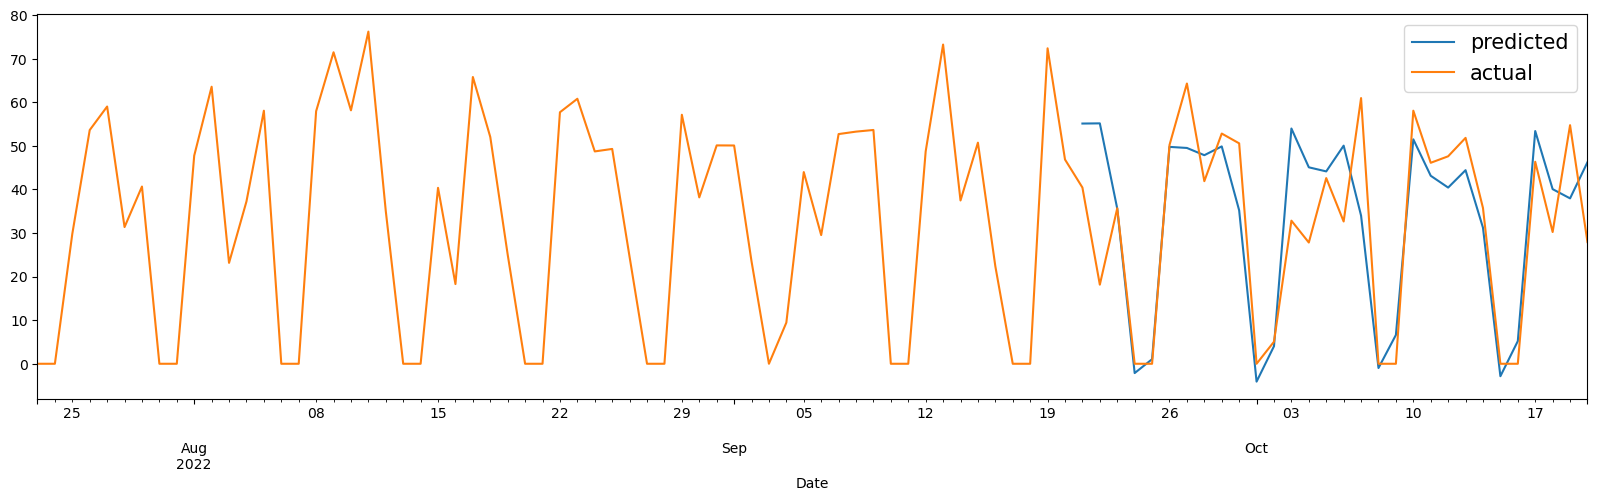

In [153]:
fig, ax = plt.subplots(figsize=[20, 5])
truepred['pred'].plot(ax = ax, label = 'predicted')
full_target['d_1'].iloc[-90:].plot(ax = ax, label = 'actual')
ax.legend(fontsize = 15)

### try with KNN5

In [97]:
all_preds = {'d_1':mlp1_preds[:len(mlp1_preds)-29]}

In [114]:
def pred_KNN5(ytrain_):
    mlp1 = MLPRegressor(hidden_layer_sizes=(256,128,64), activation='relu',
                    solver='adam',
                    alpha=0.0001,#L2
                    learning_rate='adaptive', 
                    max_iter=200, shuffle=False, random_state=None,
                    warm_start=False, momentum=0.8, 
                    early_stopping=True, validation_fraction=0.2
                    )
    mlp1.fit(xtrain.values, ytrain_)


    mlp1_preds = mlp1.predict(xtest.values)
    return mlp1_preds


In [115]:
for d in range(1,horizon):
    preds = pred_mlp1(np.array(ytrain[f"d_{d+1}"]))
    all_preds[f"d_{d+1}"] = preds
index = ytest.index
multi_o = pd.DataFrame(data=all_preds, index=index)
multi_o

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-02,28.519845,-2.258700,-1.933800,46.461166,41.432377,47.163121,41.484496,31.550276,-3.816709,4.082369,...,37.811013,31.479273,-3.882790,-5.103987,43.356732,39.138628,42.526628,35.662240,36.420554,-4.683171
2022-09-03,-0.107127,3.240875,43.431387,39.606326,51.277989,44.941015,29.782518,-5.449810,2.793178,41.833326,...,18.737298,-5.306597,4.741430,42.111242,38.400022,44.078234,41.438176,27.070186,-2.240505,0.408940
2022-09-04,1.212908,47.076645,44.355183,50.072451,46.258903,33.445677,-4.590141,3.631149,42.029904,35.127362,...,-0.609878,2.782122,41.086451,37.429256,41.704059,42.777671,34.170821,-1.344321,0.413185,39.493886
2022-09-05,39.787754,46.903147,46.427977,46.322439,31.240387,-0.820808,3.484300,42.458165,38.402412,34.863028,...,0.636942,44.466512,42.629013,39.115120,42.824721,26.905404,-1.847999,-0.322952,32.680769,38.676636
2022-09-06,42.861390,44.534207,46.701505,29.257302,3.830530,2.596730,38.175385,37.850485,41.636070,39.952717,...,35.397188,36.794978,37.811908,41.771537,26.743993,-7.921580,1.095440,31.800251,31.583064,38.796744
2022-09-07,49.910645,48.697476,29.706254,0.812945,1.940414,36.745722,39.637507,40.425417,46.664126,20.581157,...,32.041270,33.769841,33.914732,25.726853,-3.024547,3.519941,34.710235,32.310914,26.714757,45.351293
2022-09-08,39.810981,35.548206,1.343769,2.743059,46.556719,35.862432,41.782922,47.017739,36.362598,-1.102856,...,41.648131,41.221783,26.862015,-5.598481,3.820737,37.405937,31.028470,35.823723,42.444241,25.996726
2022-09-09,25.353594,-0.687167,3.164055,45.554223,43.259607,42.840445,40.125228,30.702788,-0.924288,1.199201,...,41.811025,27.996291,-3.390923,0.649204,37.479133,37.221326,38.761250,39.479966,21.282989,-3.633861
2022-09-10,0.294277,1.427804,43.383045,41.215774,48.636568,53.076889,37.351259,-1.167462,-0.755726,43.359743,...,35.550269,-0.059569,1.475798,39.264446,34.653914,44.228197,50.271332,31.907207,-1.299197,1.771697


In [121]:
multi_o.iloc[-30]


d_1     55.124811
d_2     55.167263
d_3     35.604487
d_4     -2.136218
d_5      1.047961
d_6     49.770158
d_7     49.523744
d_8     47.863707
d_9     49.880125
d_10    35.202111
d_11    -4.097071
d_12     4.028752
d_13    53.987477
d_14    45.081657
d_15    44.143335
d_16    50.053208
d_17    33.999375
d_18    -0.974936
d_19     6.612088
d_20    51.505133
d_21    43.141950
d_22    40.432592
d_23    44.425183
d_24    31.222585
d_25    -2.855394
d_26     5.199012
d_27    53.408683
d_28    40.073034
d_29    37.953220
d_30    46.255944
Name: 2022-09-21 00:00:00, dtype: float64

In [126]:
np.array(ytest.iloc[-30])

array([40.44, 18.15, 35.68,  0.  ,  0.  , 50.19, 64.31, 41.9 , 52.83,
       50.58,  0.  ,  5.06, 32.84, 27.82, 42.61, 32.65, 60.97,  0.  ,
        0.  , 58.08, 46.12, 47.61, 51.84, 35.75,  0.  ,  0.  , 46.35,
       30.23, 54.75, 27.93])

In [129]:
# prediction 30 days ahead from 21/09/2022
truepred = pd.DataFrame(data = {'true':np.array(ytest.iloc[-30]), 
                               'pred': np.array(multi_o.iloc[-30])},
                        index = ytest[-30:].index)
truepred

,true,pred
Date,,
2022-09-21,40.44,55.124811
2022-09-22,18.15,55.167263
2022-09-23,35.68,35.604487
2022-09-24,0.00,-2.136218
2022-09-25,0.00,1.047961
2022-09-26,50.19,49.770158
2022-09-27,64.31,49.523744
2022-09-28,41.90,47.863707
2022-09-29,52.83,49.880125


In [139]:
def get_pre2(true, pred,threshold = 0.1): # the difference is not bigger than 3
    TP = 0
    for i in range(len(true)):
        if true.iloc[i] == 0:
            if abs(true[i]-pred[i]) <= 3:
                TP +=1 
        else:
            if abs(true[i]-pred[i])/true[i] <= threshold:
                TP +=1
    return TP/len(true)

In [140]:
out21 = {'mae': getmetrics(truepred['true'], truepred['pred'])[0],
         'r2':  getmetrics(truepred['true'], truepred['pred'])[1],
        'precision':get_pre2(truepred['true'], truepred['pred'])}
out21

{'mae': 9.34141286125864, 'r2': 0.6406786126791508, 'precision': 0.3}

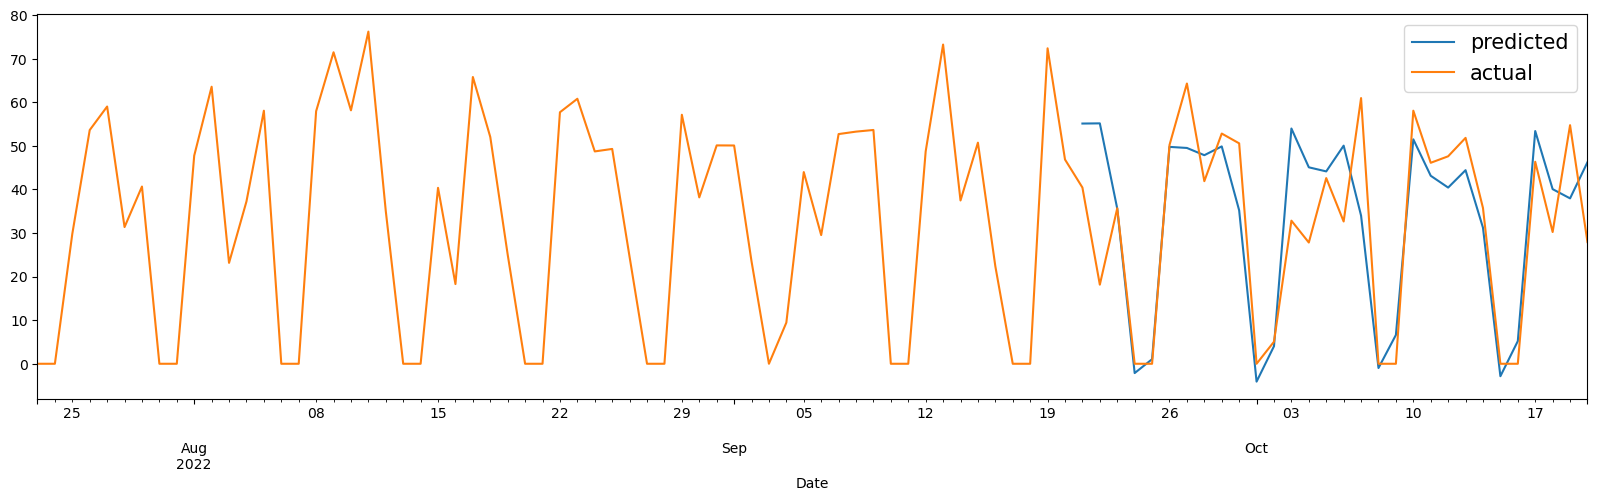

In [153]:
fig, ax = plt.subplots(figsize=[20, 5])
truepred['pred'].plot(ax = ax, label = 'predicted')
full_target['d_1'].iloc[-90:].plot(ax = ax, label = 'actual')
ax.legend(fontsize = 15)

In [138]:

# The forecasting horizon.
horizon = 30

# Create an empty dataframe for the new targets.
full_target = pd.DataFrame(index=target.index)

for d in range(horizon):
    full_target[f"d_{d+1}"] = target.shift(periods=-d, freq="D")
full_target.shape
    

full_target[32:]

target

full_target.dropna(inplace=True)


iput = all_ip.loc[full_target.index]
full_target.shape,iput.shape, iput.index.min(), iput.index.max()

# Spliting point
predicting_point_test = pd.Timestamp('2022-09-02')

xtrain = iput.loc[iput.index < predicting_point_test]

xtest = iput.loc[iput.index >= predicting_point_test]

ytrain = full_target.loc[full_target.index < predicting_point_test]
ytest = full_target.loc[full_target.index >= predicting_point_test]

ytest

all_preds = {'d_1':mlp1_preds[:len(mlp1_preds)-29]}

def pred_mlp1(ytrain_):
    mlp1 = MLPRegressor(hidden_layer_sizes=(256,128,64), activation='relu',
                    solver='adam',
                    alpha=0.0001,#L2
                    learning_rate='adaptive', 
                    max_iter=200, shuffle=False, random_state=None,
                    warm_start=False, momentum=0.8, 
                    early_stopping=True, validation_fraction=0.2
                    )
    mlp1.fit(xtrain.values, ytrain_)


    mlp1_preds = mlp1.predict(xtest.values)
    return mlp1_preds


for d in range(1,horizon):
    preds = pred_mlp1(np.array(ytrain[f"d_{d+1}"]))
    all_preds[f"d_{d+1}"] = preds
index = ytest.index
multi_o = pd.DataFrame(data=all_preds, index=index)
multi_o

multi_o.iloc[-30]


np.array(ytest.iloc[-30])

# prediction 30 days ahead from 21/09/2022
truepred = pd.DataFrame(data = {'true':np.array(ytest.iloc[-30]), 
                               'pred': np.array(multi_o.iloc[-30])},
                        index = ytest[-30:].index)
truepred

def get_pre2(true, pred,threshold = 0.1): # the difference is not bigger than 3
    TP = 0
    for i in range(len(true)):
        if true.iloc[i] == 0:
            if abs(true[i]-pred[i]) <= 3:
                TP +=1 
        else:
            if abs(true[i]-pred[i])/true[i] <= threshold:
                TP +=1
    return TP/len(true)

out21 = {'mae': getmetrics(truepred['true'], truepred['pred'])[0],
         'r2':  getmetrics(truepred['true'], truepred['pred'])[1],
        'precision':get_pre2(truepred['true'], truepred['pred'])}
out21

fig, ax = plt.subplots(figsize=[20, 5])
truepred['pred'].plot(ax = ax, label = 'predicted')
full_target['d_1'].iloc[-90:].plot(ax = ax, label = 'actual')
ax.legend(fontsize = 15)

18.15